In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path: sys.path.remove('/opt/ros/melodic/lib/python2.7/dist-packages')
import cv2 
from PIL import Image
from pathlib import Path
import glob

In [2]:
import tensorflow as tf
try:
    tf.config.experimental.set_memory_growth((tf.config.experimental.list_physical_devices('GPU'))[0], True)
except:
    pass
from math import pi
from sklearn.preprocessing import normalize

In [3]:
# Definitions
DATA_DIR = "/home/kate/catkin_ws/src/thesis/DATASETS/Dataset/"
DEPTH_FILE, RGB_FILE, SEGMENT_FILE = "depth0.png", "rgb0.png", "Segments_0.png"
NUM_SEGMENTS = 9 # 10 needed, 2 additional
SEGMENT_NAMES = ["_background_", "table", "cup", "bottle", "glass", "fork", "knife", "food", "plate"]

# Camera information
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 720, 1280, 4 # Shape of the images
OUT_SHAPE = (720, 1280)

In [4]:
def __getRGB(thisPath): 
#     """Internal: tf-pure function to return the RGB Image of a datatpoint"""
    png = tf.io.read_file(thisPath, name="read_file_RGB")
    png = tf.image.decode_png(png, name="RGB_Decoding")
    png = tf.image.convert_image_dtype(png, tf.float32, name="RGB_RangeChange")
    png.set_shape((IMG_HEIGHT, IMG_WIDTH, 3))
    return png

def __getD(thisPath): 
#      """Internal: tf-pure function to return the Depth Image of a datatpoint"""
    D = tf.io.read_file(thisPath, name="read_file_Depth")
    D = tf.image.decode_png(D, dtype=tf.uint16, name="Depth_Decoding")
    D = tf.cast(D, tf.float32, name="Depth_uint16_to_float32")
    D = tf.math.reciprocal_no_nan(D, name="Invert_Depth")
    D.set_shape((IMG_HEIGHT, IMG_WIDTH, 1))
    return D

def __getSegments(thisPath): 
#     """Internal: tf-pure function to return the Segment Image-Set of a datatpoint"""
    S = tf.io.read_file(thisPath, name="read_file_Segments")
    S = tf.image.decode_png(S, name="Segments_Decoding")[:,:,0]
    S = tf.squeeze(S, name="Segments_Squeezing")
    S = tf.one_hot(S, NUM_SEGMENTS, name="One_Hot_Segments")
    S.set_shape((IMG_HEIGHT, IMG_WIDTH, NUM_SEGMENTS))
    S = tf.image.resize(S, size=OUT_SHAPE)
    return S
   
@tf.function

def loadDatapoint(paths):
#     """Loads a single datapoint and returns the (4+NUM_SEGMENTS+3) Channel x-Image and the label"""
    RGB = __getRGB(paths+"/"+RGB_FILE)
    D = __getD(paths+"/"+DEPTH_FILE)
    S = __getSegments(paths+"/"+SEGMENT_FILE)
    x = tf.concat([RGB,D], axis=2, name="Stack_RGB_D")
    return x, S

In [5]:
def showDatapoint(x,y):
    """Represent a single datapoint in ipynb-readable format"""
    image, label = x, y 
    img = image.numpy()
    C = img[:,:,:3]
    D = img[:,:,3]
    S = label
    plt.figure("Images", figsize=(30,2))
    plt.subplot(1,3,1)
    I_C= plt.imshow(C)
    plt.title("RGB")
    plt.subplot(1,3,2)
    I_D=plt.imshow(D)
    plt.title("Depth$^{-1}$")
    for i in (I_C,I_D):
        i.axes.get_yaxis().set_visible(False)
        i.axes.get_xaxis().set_visible(False)
    plt.show()
    f1 = plt.figure("Segments", figsize=(30, 2))
    f1.suptitle("Segments")
    for i in range(NUM_SEGMENTS):
        s = S[:,:,i]
        plt.subplot(1,NUM_SEGMENTS,i+1)
        if i < len(SEGMENT_NAMES):
            plt.title(SEGMENT_NAMES[i])
        else: plt.title("Placeholder")
        I_S = plt.imshow(s, vmin=0, vmax=1)
        I_S.axes.get_yaxis().set_visible(False)
        I_S.axes.get_xaxis().set_visible(False)
    plt.show()
    

In [8]:
def getDataset(datasetPath, batch_size=None, batch_drop_remainder=False, cache=None, prefetch_buffer_size=tf.data.experimental.AUTOTUNE, testPercentage=20, random_seed=13):
#    """Returns the seed-defined shuffled dataset from the csv as train_set, test_set
#         Parameters:
#         datasetPath: The path to the dataset
#         batch_size: batch size to run with
#         cache: From the dataset doku: filename: 
#             A tf.string scalar tf.Tensor, representing the name of a directory on the filesystem to 
#             use for caching elements in this Dataset. If a filename is not provided, the dataset will 
#             be cached in memory.
#         prefetch_buffer_size: buffer size used in prefetching
#         testPercentage: Percentage of the data used for testing
#         random_seed: seed used by numpy to shuffle the dataset """

    DATASET_LENGTH = 99
    testPercentage = 10  # Percentage of data used for testing
    dsSplit = int(DATASET_LENGTH*testPercentage/100.) # Number of items in training set
    paths = [datasetPath+str(i)+"/" for i in range(1,100) if not 0 ]
    np.random_seed=random_seed
    np.random.shuffle(paths)
    ds = tf.data.Dataset.from_tensor_slices((paths))
    ds = ds.map(loadDatapoint, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
    if cache:
        ds = ds.cache(cache)
    if batch_size:
        ds = ds.batch(batch_size, drop_remainder=batch_drop_remainder)
    if prefetch_buffer_size:
        ds = ds.prefetch(buffer_size=prefetch_buffer_size)
    return ds.skip(dsSplit), ds.take(dsSplit)

In [9]:
if __name__ == "__main__":
    dsTrain, dsTest = getDataset(datasetPath = 
                             DATA_DIR, 
                             batch_size=8)#, batch_drop_remainder=True, cache=None)#"~")

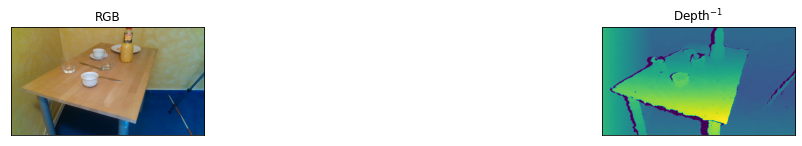

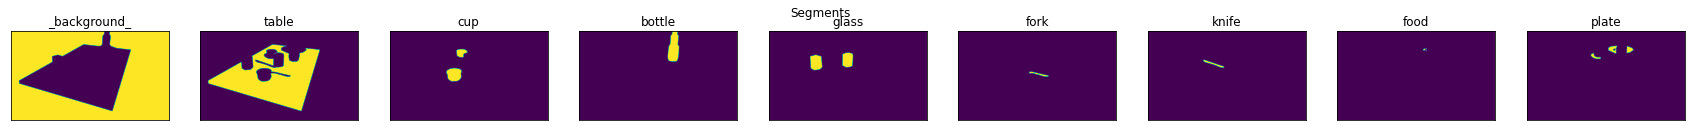

In [10]:
for i,j in dsTrain:
    showDatapoint(i[0],j[0])
    break
        

In [11]:
from keras.models import Sequential
from keras.layers import Dense 
from keras import layers
from keras import backend as K
from keras import Input

# channels = 9

Using TensorFlow backend.


In [12]:
def downsampling_block(x, basename, channels):
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"expand")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_expand_BN')(x)
    x = layers.ReLU(6., name=basename+'_expand_relu')(x)
    
    x = layers.ZeroPadding2D(padding=((1,0), (1,0)), name=basename+'_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=(2, 2), depth_multiplier=1, activation=None, use_bias=False, padding='valid',name=basename+'_depthwise')(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_depthwise_BN')(x)
    x = layers.ReLU(max_value=6, negative_slope=0, threshold=0, name=basename+'_depthwise_relu' )(x)

    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_project")(x)
#     x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_project_BN')(x)
    return x
    

In [13]:
def conv_block(x, basename, channels):
    x = layers.Conv2D (channels, 1, padding='same', name = basename+"expand")(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_expand_BN')(x)
    x = layers.ReLU(6., name=basename+'_expand_relu')(x)
    
    x = layers.DepthwiseConv2D(kernel_size=3, depth_multiplier=1, activation=None, use_bias=False, padding='same',name=basename+'_depthwise')(x)
    x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_depthwise_BN')(x)
    x = layers.ReLU(max_value=6, negative_slope=0, threshold=0, name=basename+'_depthwise_relu' )(x)

    x = layers.Conv2D (channels, 1, padding='same', name = basename+"_project")(x)
#     x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name=basename+'_project_BN')(x)
    return x

In [14]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

model = Sequential()
inl = tf.keras.Input(shape=input_shape)
x = layers.ZeroPadding2D(padding=((1,0), (1,0)),name="Conv1_pad")(inl)
x = layers.Conv2D (9, kernel_size=3, strides=(2, 2), padding='valid', name = "Conv1")(x)
x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="bn1_Conv1")(x)
x = layers.ReLU(6., name='Conv1_relu')(x)
x = layers.DepthwiseConv2D(kernel_size=3, depth_multiplier=1, activation=None, use_bias=False, padding='same',name="expanded_conv_depthwise")(x)
x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="expanded_conv_depthwise_BN")(x)
x = layers.ReLU(6., name='expanded_conv_depthwise_relu')(x)
x = layers.Conv2D (9, 1, padding='same', name = "expanded_conv_project")(x)
expanded_conv_project_BN = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="expanded_conv_project_BN")(x)
x = downsampling_block(expanded_conv_project_BN,"block_1",10)
bn_1_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_1_project_BN")(x)
x = conv_block(bn_1_layer,"block_2",9)
bn_2_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_2_project_BN")(x)
add_2 = layers.Add(name="block_2_add")([bn_1_layer,bn_2_layer])
x = downsampling_block(add_2,"block_3",9)
bn_3_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_3_project_BN")(x)
x = conv_block(bn_3_layer,"block_4",9)
bn_4_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_4_project_BN")(x)
add_4 = layers.Add(name="block_4_add")([bn_3_layer,bn_4_layer])
x = conv_block(add_4,"block_5",9)
bn_5_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_5_project_BN")(x)
add_5 = layers.Add(name="block_5_add")([add_4,bn_5_layer])
x = downsampling_block(add_5,"block_6",9)
bn_6_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_6_project_BN")(x)
x = conv_block(bn_6_layer,"block_7",9)
bn_7_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_7_project_BN")(x)
add_7 = layers.Add(name="block_7_add")([bn_6_layer,bn_7_layer])
x = conv_block(add_7,"block_8",9)
bn_8_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_8_project_BN")(x)
add_8 = layers.Add(name="block_8_add")([add_7,bn_8_layer])
x = conv_block(add_8,"block_9",9)
bn_9_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_9_project_BN")(x)
add_9 = layers.Add(name="block_9_add")([add_8,bn_9_layer])
x = conv_block(add_9,"block_10",9)
bn_10_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_10_project_BN")(x)
# add_10 = layers.Add(name="block_10_add")([add_9,bn_10_layer])
x = conv_block(bn_10_layer,"block_11",9)
bn_11_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_11_project_BN")(x)
add_11 = layers.Add(name="block_11_add")([bn_10_layer,bn_11_layer])
x = conv_block(add_11,"block_12",9)
bn_12_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_12_project_BN")(x)
add_12 = layers.Add(name="block_12_add")([bn_11_layer,bn_12_layer])
x = layers.Conv2D (9, 1, padding='same', name = "block_13_expand")(add_12)
x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_13_expand_BN")(x)
x = layers.ReLU(6.,name ='block_13_expand_relu')(x)

x = layers.ZeroPadding2D(padding=((1,0), (1,1)), name='block_13_pad')(x)
x = layers.DepthwiseConv2D(kernel_size=3, strides=(2, 2), depth_multiplier=1, activation=None, use_bias=False, padding='valid',name='block_13w_depthwise')(x)
x = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name='block_13_depthwise_BN')(x)
x = layers.ReLU(max_value=6, negative_slope=0, threshold=0, name='block_13_depthwise_relu' )(x)

x = layers.Conv2D (9, 1, padding='same', name = "block_13_project")(x)
# x = downsampling_block(add_12,"block_13",10)
bn_13_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_13_project_BN")(x)
x = conv_block(bn_13_layer,"block_14",9)
bn_14_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_14_project_BN")(x)
add_14 = layers.Add(name="block_14_add")([bn_13_layer,bn_14_layer])
x = conv_block(add_14,"block_15",9)
x = conv_block(x,"block_16",9)
bn_16_layer = layers.BatchNormalization(axis=-1, epsilon=1e-3, momentum=0.999, name="block_16_project_BN")(x)
x = layers.Conv2D (9, 1, padding='same', activation='relu', name = "block_18_middle_1conv_output")(bn_16_layer)
# x = layers.Conv2D (10, 1, padding='same', activation='relu', name = "block_18_middle_2conv_output")(x)
# x = layers.Conv2D (10, 1, padding='same', activation='softmax', name = "block_18_middle_3conv_output")(x)
x = layers.UpSampling2D(interpolation='bilinear', name='block_19_upto16')(bn_16_layer)
x = layers.ZeroPadding2D(padding=((1,0), (0,0)))(x)

x = layers.Concatenate(name="block_19_concat")([x,add_12])

x = layers.ReLU(max_value=None, negative_slope=0, threshold=0 )(x)
x = layers.DepthwiseConv2D(kernel_size=3, strides=(2, 2), depth_multiplier=1, activation=None, use_bias=False, padding='valid')(x)
x = layers.UpSampling2D(size=(2,2),interpolation='bilinear', name='block_19fs_upto16')(x)
x = layers.UpSampling2D(interpolation='bilinear', name='block_20_upto8')(x)
x = layers.ZeroPadding2D(padding=((1,0), (1,1)))(x)
x = layers.ZeroPadding2D(padding=((1,0), (1,1)))(x)
x = layers.Concatenate(name="block_20_concat")([x,add_5])

x = layers.UpSampling2D(interpolation='bilinear', name='block_21_upto4')(x)
x = layers.Concatenate(name="block_21_concat")([x,add_2])


x = layers.UpSampling2D(interpolation='bilinear', name='block_22_upto2')(x)
x = layers.Concatenate(name="block_22_concat")([x,expanded_conv_project_BN])


x = layers.UpSampling2D(interpolation='bilinear', name='block_23_upto1')(x)

x = layers.Conv2D (9, 1, padding='same', activation='softmax', name = "block_23_conv_output")(x)


predictions = layers.Conv2D (9, 1, padding='same', activation='softmax', name = "bflock_18_conv_output")(x)

model = keras.Model(inputs=inl,outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision()])
model.summary()

ValueError: Operands could not be broadcast together with shapes (180, 320, 10) (180, 320, 9)

In [ ]:
history = model.fit(dsTrain, epochs=1000)

In [ ]:
metrics = model.evaluate(dsTest, verbose=0)
print("Evaluated Metrics for the Test-Set:")
for name, value in zip(model.metrics_names, metrics):
    print(f"{name}: {value}")

In [ ]:
printX = dsTest.take(1)
predictedY = model.predict(printX)
m = np.argmax(predictedY, axis=-1)
predictedY = tf.one_hot(m, 10)
i=5
for x,y in printX:
    print("True Values")
    showDatapoint(x[i],y[i])
    print("Network results:")
    showDatapoint(x[i],predictedY[i])
